# Classification and Regression, from linear and logistic regression to neural networks

## Regression:
Bring back regression code from project 1 (reference own work in bibliography) and compare to results from FFNN
Data can be:
- simple 1d
- Franke
- anything
But start with something simple

## Classification:
Develop a logistic regression code and compare to FFNN.
Proposed data set:
- Wisconsin Breast Cancer Data (images representing various tumor features)
- Andre data (men pass på at kan diskutere resultatene mot literature)


## Part a) Write own Stochastic Gradient Descent Code: First step
Replace matrix inversion from OLS and Ridge with GD and SGD
Data can be either
- Franke
- Terrain 
- Recommended: something simple like for instance: f(x) = ao + a1x + a2x^2
look at exercises from week 41 for help

## Analyse the GD and SGD code. This should include:
(Lecture notes week 39 and 40 contain examples it is ok to use)
### 1: plain gradient descent with fixed learning rate (tune it) using the analytical expression for the gradient
### 2: Add momentum to the plain GD code and compare convergence with a fixed learning rate (may need to tune it). Keep using the analytical expression for the gradient
### 3: Repeat these steps for stochastic gradient descent with mini batches and a given number of epochs. Use a tunable learning rate (lectures week 39 and 40). Discuss the results as functions of the various parameters (size of batches, nr of epochs etc). Use the analytical gradient
### 4: Implement the adagrad method in order to tune the learning rate. Do this with and without momentum for plain gradient descent and SGD
### 5: Add RMSprop and Adam to your library of methods for tuning the learning rate
### 6: Replace thereafter your analytical gradient with either Autograd or JAX

## Part b) Writing your own neural network code (Central part of the project)
Implement back propagation algorithm discussed in lectures week 41 and 42
### Regression problem first: Can use simple 2nd order poly from part a, Franke or terrain. Discuss choice of cost fcn
Write a FFNN with a flexible nr of hidden layers and nodes using the sigmoid fcn as activation fcn for the hidden layers. Initialise the weights using a normal distribution. 
How would you initialise the biases?
Which activation would yuu choose for the final output layer?
Train your network and compare your results from OLS and Ridge from project 1 (if using franke or terrain)
Compare to similar code in schikit
Comment on results and compare linear regression to this FFNN
Make an analysis of the regularisation parameters and the learning rates employed to find the optimal MSE and R2 scores.

## Part c) Testing different activation functions for the hidden layers
- Sigmoid
- RELU
- Leaky RELU
Discuss the results
May also study the way you initialise the  weights and biases

## Part d) Classification analysis using neural networks

## Part e) Write your logistic regression code
To compare the FFNN code with logistic regression

## Part f) Critical evaluation of the various algorithms
Compare the results from the different algorithms, which works best for the regression case, and which one for classification? List pros and cons








In [211]:
from enum import Enum
from random import random, seed
import numpy as np

def MSE(expected_values, predicted_values):
    n = np.size(predicted_values)  # Number of data points
    return np.sum((expected_values - predicted_values)**2)/n

class ScalingAlgorithm(Enum):
    GradientDescent = 0,
    StochasticGD = 1,
    Adagrad = 2,
    RMSProp = 3,
    Adam = 4

class LinearRegressionModel(Enum):
    OrdinaryLeastSquares = 0,
    Ridge = 1

class OLS_Hessian:
    def __init__(self, n, X):
        self.H = (2.0/n)* X.T @ X
        self.EigValues, self.EigVectors = np.linalg.eig(self.H)

class Ridge_Hessian:
    def __init__(self, n, lmbda, XT_X):
        self.H = (2.0/n)* XT_X+2*lmbda* np.eye(XT_X.shape[0])
        self.EigValues, self.EigVectors = np.linalg.eig(self.H)

class LinearRegression:
    def __init__(self, x, y):
        # Design matrix including the intercept
        # No scaling of data and all data used for training 
        n = x.shape[0]
        self.design_matrix = np.c_[np.ones((n, 1)), x, x*x]

        self.x = x
        self.y = y

        self.ols_hessian = None
        self.ridge_hessian = None
    
    #Function contents taken from lecture notes
    def _gradient_descent_OLS(self, n, n_iterations, eta, momentum = None):
        #Don't wanna calculate this every time when running multiple iterations
        if not self.ols_hessian:
            self.ols_hessian = OLS_Hessian(n, self.design_matrix)
        
        betas, scores = list(), list()
        beta = np.random.randn(3,1)
        #eta = eta/np.max(self.ols_hessian.EigValues)
        change = 0.0
        for iter in range(n_iterations):
            gradient = (2.0/n)*self.design_matrix.T @ (self.design_matrix @ beta-self.y)
            #Gradient descent with momentum
            if momentum:
                new_change = eta*gradient + momentum*change
                change = new_change
                beta -= new_change

                #Store results
                betas.append(beta)
                scores.append(MSE(self.y, self.design_matrix @ beta))
            #Gradient descent without momentum
            else:
                beta -= eta*gradient

                #Store results
                betas.append(beta)
                scores.append(MSE(self.y, self.design_matrix @ beta))

        return [betas, scores]
    
    #Function contents taken from lecture notes
    def _gradient_descent_ridge(self, n, n_iterations, eta, lmbda, momentum = None): 
        #Don't wanna calculate this every time when running multiple iterations
        if not self.ridge_hessian:
            XT_X = self.design_matrix.T @ self.design_matrix
            self.ridge_hessian = Ridge_Hessian(n, lmbda, XT_X)
        
        #Id = n*lmbda* np.eye((XT_X).shape[0])

        betas, scores = list(), list()
        beta = np.random.randn(3,1)
        #eta = eta/np.max(self.ridge_hessian.EigValues)
        change = 0.0
        for iter in range(n_iterations):
            gradient = 2.0/n*self.design_matrix.T @ (self.design_matrix @ beta-self.y)+2*lmbda*beta
            #Gradient descent with momentum:
            if momentum:
                new_change = eta*gradient + momentum*change
                change = new_change
                beta -= new_change

                #Store results
                betas.append(beta)
                scores.append(MSE(self.y, self.design_matrix @ beta))
            #Gradient descent without momentum:
            else:
                beta -= eta*gradient

                #Store results
                betas.append(beta)
                scores.append(MSE(self.y, self.design_matrix @ beta))

        return [betas, scores]
    
    def gradient_descent(self, lin_reg_model, n_datapoints, n_iterations, learning_rate, lmbda = None, nr_minibatches = None, epochs = None, scaling_algorithm = None):
        if nr_minibatches or epochs or scaling_algorithm:
            return NotImplementedError
        
        match lin_reg_model:
            case LinearRegressionModel.OrdinaryLeastSquares:
                betas, scores = self._gradient_descent_OLS(n_datapoints, n_iterations, learning_rate)
            
            case LinearRegressionModel.Ridge:
                if not lmbda:
                    raise ValueError("Lambda value cannot be null")
                betas, scores = self._gradient_descent_ridge(n_datapoints, n_iterations, learning_rate, lmbda)
                
        return [betas, scores]
    
    def gradient_descent_momentum(self, lin_reg_model, n_datapoints, n_iterations, learning_rate, momentum, lmbda=None):
        match lin_reg_model:
            case LinearRegressionModel.OrdinaryLeastSquares:
                betas, scores = self._gradient_descent_OLS(n_datapoints, n_iterations, learning_rate, momentum)
            
            case LinearRegressionModel.Ridge:
                if not lmbda:
                    raise ValueError("Lambda value cannot be null")
                betas, scores = self._gradient_descent_ridge(n_datapoints, n_iterations, learning_rate, lmbda, momentum)
                
        
        return [betas, scores]
    
    def _learning_schedule(self, t):
        t0, t1 = 5, 50
        return t0/(t+t1)
    
    def _SGD(self, beta, lin_reg_model, epoch, M, m, lmbda = None):
        for iter in range(m):
            random_index = M*np.random.randint(m)
            xi = self.design_matrix[random_index:random_index+M]
            yi = self.y[random_index:random_index+M]

            y_tilde = xi @ beta
            gradients = (2.0/M)* xi.T @ (y_tilde-yi)
            match lin_reg_model:
                case LinearRegressionModel.Ridge:
                    if not lmbda:
                        raise ValueError("Lambda cannot be null for Ridge regression")
                    gradients += 2*lmbda*beta
            t = epoch*m+iter
            eta = self._learning_schedule(t)
            beta -= eta*gradients
 
        return beta

    
    def SGD_OLS(self, n_datapoints, batch_size, n_epochs):
        m = int(n_datapoints/batch_size)
        beta = np.random.randn(3,1)

        betas, scores = list(), list()
        for epoch in range(n_epochs):
            beta = self._SGD(beta, LinearRegressionModel.OrdinaryLeastSquares, epoch, batch_size, m)
            
            #Store results
            betas.append(beta)
            scores.append(MSE(self.y, self.design_matrix @ beta))
        
        return [betas, scores]
    
    def SGD_Ridge(self, n_datapoints, batch_size, n_epochs, lmbda):
        m = int(n_datapoints/batch_size)
        beta = np.random.randn(3,1)

        betas, scores = list(), list()
        for epoch in range(n_epochs):
            beta = self._SGD(beta, LinearRegressionModel.Ridge, epoch, batch_size, m, lmbda)

            #Store results
            betas.append(beta)
            scores.append(MSE(self.y, self.design_matrix @ beta))

        return [betas, scores]

               
        

In [172]:
def Get_best_mse_and_eta(mse_data, learning_rates):
    min_mse = np.min(mse_data)
    best_index = np.argmin(mse_data)
    best_learning_rate = learning_rates[best_index]

    return [min_mse, best_learning_rate]

Best learning rate for OLS: 0.1 with MSE: 0.9591698014302489
Best learning rate for Ridge: 0.1 with MSE: 0.9753662898814747


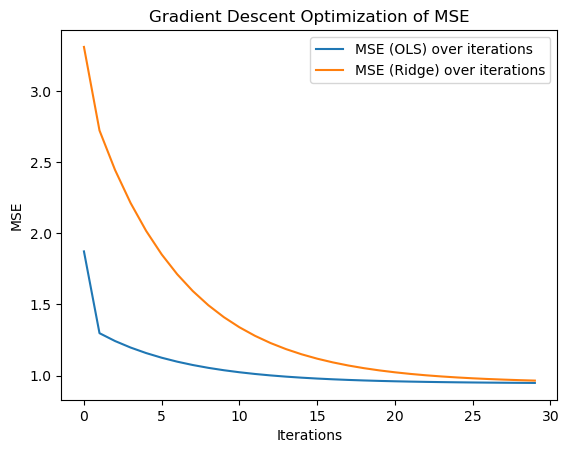

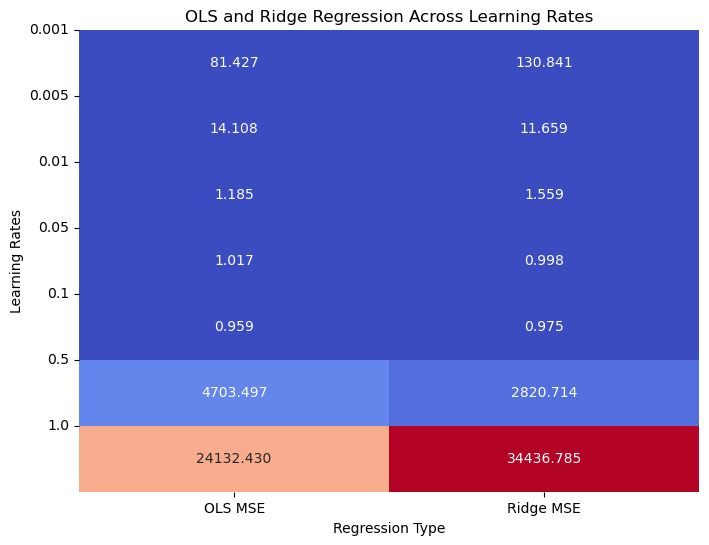

In [192]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#Set-up taken from lecture notes
n = 100
x = 2*np.random.rand(n,1)
y = 4+3*x+5*x*x + np.random.randn(n, 1)

N_iterations = 30

linear_regression = LinearRegression(x, y)

#Gradient descent
learning_rates = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1])
mse_data = np.zeros((len(learning_rates), 2))  # Rows for learning rates, columns for OLS and Ridge
for i, eta in enumerate(learning_rates):
    ols_betas, ols_mses = linear_regression.gradient_descent(LinearRegressionModel.OrdinaryLeastSquares, n, N_iterations, eta)
    mse_data[i, 0] = min(ols_mses)
    ridge_betas, ridge_mses = linear_regression.gradient_descent(LinearRegressionModel.Ridge, n, N_iterations, eta, lmbda=0.01)
    mse_data[i, 1] = min(ridge_mses)

    #print(f"OLS - eta: {eta}, mse: {ols_mse}")
    #print(f"Ridge - eta: {eta}, mse: {ridge_mse}")


# Find the minimum MSE and corresponding index
ols_min_mse, ols_best_eta = Get_best_mse_and_eta(mse_data[:, 0], learning_rates)
ridge_min_mse, ridge_best_eta = Get_best_mse_and_eta(mse_data[:, 1], learning_rates)

# Print results
print(f"Best learning rate for OLS: {ols_best_eta} with MSE: {ols_min_mse}")
print(f"Best learning rate for Ridge: {ridge_best_eta} with MSE: {ridge_min_mse}")

# Get values for the best learning rate: (I am lazy and run it again rather than rewrite the loop above to store it)
ols_betas, ols_mses = linear_regression.gradient_descent(LinearRegressionModel.OrdinaryLeastSquares, n, N_iterations, ols_best_eta)
ridge_betas, ridge_mses = linear_regression.gradient_descent(LinearRegressionModel.Ridge, n, N_iterations, ridge_best_eta, lmbda=0.01)


# Plot MSE over iterations
plt.plot(range(N_iterations), ols_mses, label="MSE (OLS) over iterations")
plt.plot(range(N_iterations), ridge_mses, label="MSE (Ridge) over iterations")
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title("Gradient Descent Optimization of MSE")
plt.legend()
plt.show()


# Create a DataFrame for heatmap plotting
mse_df = pd.DataFrame(mse_data, columns=['OLS MSE', 'Ridge MSE'], index=learning_rates)

# Plot the heatmap
plt.figure(figsize=(8, 6))
#sns.heatmap(mse_df, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'MSE'})
sns.heatmap(mse_df, annot=True, fmt=".3f", cmap="coolwarm", cbar=False)
plt.title("OLS and Ridge Regression Across Learning Rates")
plt.xlabel("Regression Type")
plt.ylabel("Learning Rates")
plt.xticks(ticks=np.arange(0.5, 2), labels=mse_df.columns, rotation=0)
plt.yticks(ticks=np.arange(len(learning_rates)), labels=mse_df.index, rotation=0)
plt.show()




Best learning rate for OLS: 0.1 with MSE: 0.003268182938909006
Best learning rate for Ridge: 0.1 with MSE: 0.0034850642743450484


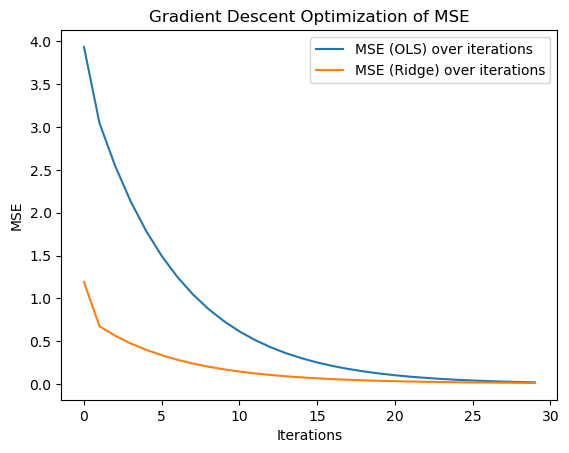

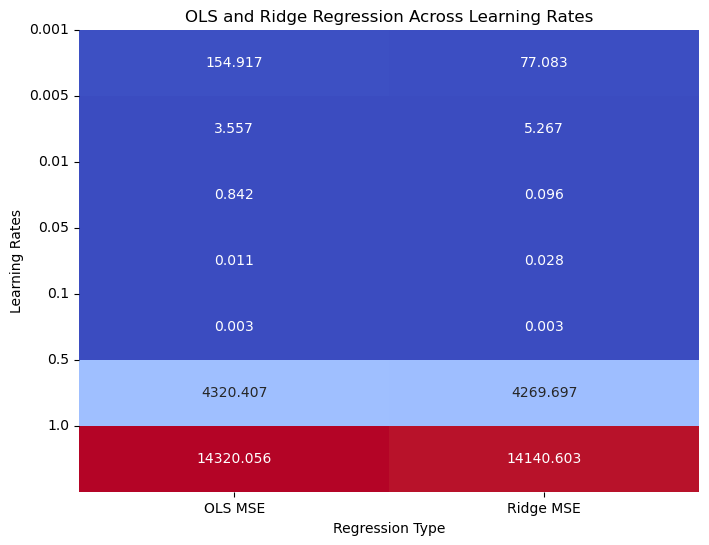

In [193]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#Set-up taken from lecture notes
n = 100
x = 2*np.random.rand(n,1)
y = 4+3*x+5*x*x

momentum = 0.3
N_iterations = 30

linear_regression = LinearRegression(x, y)

#Gradient descent with momentum
learning_rates = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1])
mse_data = np.zeros((len(learning_rates), 2))  # Rows for learning rates, columns for OLS and Ridge
for i, eta in enumerate(learning_rates):
    #OLS
    ols_betas, ols_mses = linear_regression.gradient_descent_momentum(LinearRegressionModel.OrdinaryLeastSquares, n, N_iterations, eta, momentum)
    mse_data[i, 0] = min(ols_mses)
    ridge_betas, ridge_mses = linear_regression.gradient_descent_momentum(LinearRegressionModel.Ridge, n, N_iterations, eta, momentum, lmbda=0.01)
    mse_data[i, 1] = min(ridge_mses)

    #print(f"OLS - eta: {eta}, mse: {ols_mse}    Ridge - eta: {eta}, mse: {ridge_mse}")

# Find the minimum MSE and corresponding index
ols_min_mse, ols_best_eta = Get_best_mse_and_eta(mse_data[:, 0], learning_rates)
ridge_min_mse, ridge_best_eta = Get_best_mse_and_eta(mse_data[:, 1], learning_rates)

# Print results
print(f"Best learning rate for OLS: {ols_best_eta} with MSE: {ols_min_mse}")
print(f"Best learning rate for Ridge: {ridge_best_eta} with MSE: {ridge_min_mse}")

# Get values for the best learning rate: (I am lazy and run it again rather than rewrite the loop above to store it)
ols_betas, ols_mses = linear_regression.gradient_descent(LinearRegressionModel.OrdinaryLeastSquares, n, N_iterations, ols_best_eta)
ridge_betas, ridge_mses = linear_regression.gradient_descent(LinearRegressionModel.Ridge, n, N_iterations, ridge_best_eta, lmbda=0.01)


# Plot MSE over iterations
plt.plot(range(N_iterations), ols_mses, label="MSE (OLS) over iterations")
plt.plot(range(N_iterations), ridge_mses, label="MSE (Ridge) over iterations")
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title("Gradient Descent Optimization of MSE")
plt.legend()
plt.show()

# Create a DataFrame for heatmap plotting
mse_df = pd.DataFrame(mse_data, columns=['OLS MSE', 'Ridge MSE'], index=learning_rates)

# Plot the heatmap
plt.figure(figsize=(8, 6))
#sns.heatmap(mse_df, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'MSE'})
sns.heatmap(mse_df, annot=True, fmt=".3f", cmap="coolwarm", cbar=False)
plt.title("OLS and Ridge Regression Across Learning Rates w/ Memory")
plt.xlabel("Regression Type")
plt.ylabel("Learning Rates")
plt.xticks(ticks=np.arange(0.5, 2), labels=mse_df.columns, rotation=0)
plt.yticks(ticks=np.arange(len(learning_rates)), labels=mse_df.index, rotation=0)
plt.show()




Best nr of epochs for OLS: 10 with MSE: 0.944610925228182
Best nr of epochs for Ridge: 1 with MSE: 0.874928695489508


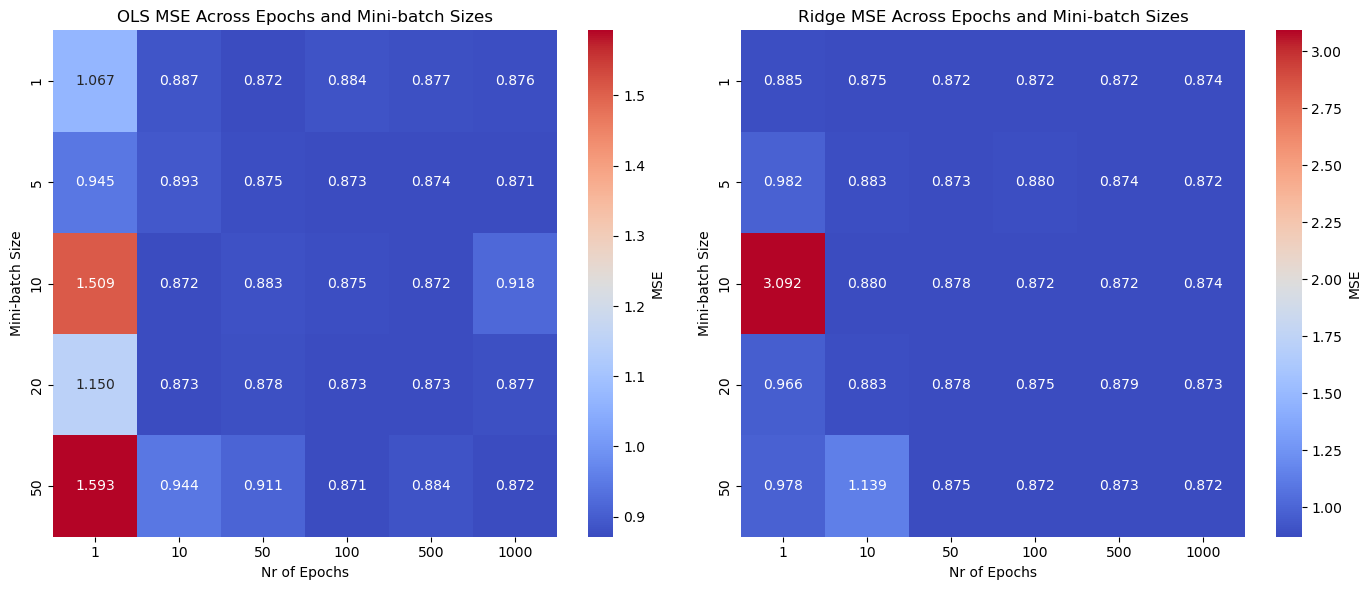

In [236]:
#SGD with batches and epocs

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


n = 100
x = 2*np.random.rand(n,1)
y = 4+3*x+5*x*x + np.random.randn(n, 1)

M = 5 #size of each minibatch
n_epochs = 10 

N_iterations = 100

#linear_regression = LinearRegression(x, y)

#Test for different nr epochs
epochs = np.array([1, 10, 50, 100, 500, 1000])
#.. and batch size
batch_sizes = np.array([1, 5, 10, 20, 50])
mse_data_ols = np.zeros((len(batch_sizes), len(epochs)))  # Arrays for epochs and batch sizes
mse_data_ridge = np.zeros((len(batch_sizes), len(epochs)))  # Arrays for epochs and batch sizes
for j, M in enumerate(batch_sizes):
    for i, n_epochs in enumerate(epochs):
        beta_ols, scores_ols = linear_regression.SGD_OLS(n, M, n_epochs)
        mse_data_ols[j, i] = min(scores_ols)

        beta_ridge, scores_ridge = linear_regression.SGD_Ridge(n, M, n_epochs, lmbda=0.01)
        mse_data_ridge[j, i] = min(scores_ridge)

# Find the minimum MSE and corresponding index
ols_min_mse, ols_best_nEpochs = Get_best_mse_and_eta(mse_data_ols[:, 0], epochs)
ridge_min_mse, ridge_best_nEpochs = Get_best_mse_and_eta(mse_data_ridge[:, 1], epochs)

# Print results
print(f"Best nr of epochs for OLS: {ols_best_nEpochs} with MSE: {ols_min_mse}")
print(f"Best nr of epochs for Ridge: {ridge_best_nEpochs} with MSE: {ridge_min_mse}")


# Create a DataFrame for heatmap plotting
mse_df_ols = pd.DataFrame(mse_data_ols, index=batch_sizes, columns=epochs)
mse_df_ridge = pd.DataFrame(mse_data_ridge, index=batch_sizes, columns=epochs)


# Plot the heatmap
plt.figure(figsize=(14, 6))
# #sns.heatmap(mse_df, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'MSE'})
# sns.heatmap(mse_df, annot=True, fmt=".3f", cmap="coolwarm", cbar=False)
# plt.title("OLS and Ridge Regression Across Epochs")
# plt.xlabel("Regression Type")
# plt.ylabel("Nr of Epochs")
# plt.xticks(ticks=np.arange(0.5, 2), labels=mse_df.columns, rotation=0)
# plt.yticks(ticks=np.arange(len(epochs)), labels=mse_df.index, rotation=0)
# plt.show()

# OLS MSE Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(mse_df_ols, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'MSE'})
plt.title("OLS MSE Across Epochs and Mini-batch Sizes")
plt.xlabel("Nr of Epochs")
plt.ylabel("Mini-batch Size")

# Ridge MSE Heatmap
plt.subplot(1, 2, 2)
sns.heatmap(mse_df_ridge, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'MSE'})
plt.title("Ridge MSE Across Epochs and Mini-batch Sizes")
plt.xlabel("Nr of Epochs")
plt.ylabel("Mini-batch Size")

plt.tight_layout()
plt.show()


In [ ]:
#Vary batch size, nr epochs